# Models without Framepooling

In this notebook, we explore some model archtectures that do not use framepooling, but nevertheless work on arbitrary sequence lengths. Specifically we will use at convnets with "normal" global pooling and random forests

In [1]:
## Imports
# base python
from importlib import reload
import re
import itertools
import random
import os
from pathlib import Path
random.seed(1337)
import pickle
from decimal import Decimal
import collections

# numpy and similar
import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine

In [2]:
# Deep Learning related packages and scripts
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Use gpu?
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
# modelling and utility code
import model
import utils_data
import utils

# saving svg images
#from IPython.display import SVG

Using TensorFlow backend.


In [3]:
from sklearn import ensemble, preprocessing, pipeline, model_selection, metrics
from joblib import dump, load

# **Reading in the data**
Reading in the data pickle to run model training

In [4]:
with open(Path("../Data/data_dict.pkl"), 'rb') as handle:
    data_dict = pickle.load(handle)

In [5]:
# Load predictions for framepool models
mpra_pred_df = pd.read_csv(Path("../Data/Predictions/mpra_random_prediction.csv")).drop("Unnamed: 0", axis=1)
mpra_pred_df_human = pd.read_csv(Path("../Data/Predictions/mpra_human_prediction.csv")).drop("Unnamed: 0", axis=1)

Functions for RF

In [6]:
def rf_predict_on_MPRA(model, kmer_extractor, data_dict, varlen = False, library = "egfp_unmod_1"):
    if varlen:
        data_df = data_dict["varlen_mpra"].copy()
    else:
        data_df = data_dict["mpra"].copy()
    df = data_df[(data_df.library == library) & (data_df.set == "test")]
    generator = utils_data.DataSequence(df, encoding_functions=[], precomputations=[kmer_extractor], shuffle=False, batch_size=len(df))
    X = [X[0] for X in generator][0]
    predict = model.predict(X)
    df["pred"] = predict
    df = df.rename(columns={"pred": "Predicted MRL", "rl": "Observed MRL"})
    return df

def build_rf_mpra_prediction(predmodel, kmer_extractor, modelname, human=False):
    concat_df = pd.DataFrame(columns=['Predicted MRL', 'Observed MRL', 'model', 'data', 'R'])
    data_types = [("Fixed length (50 nt) MPRA", "egfp_unmod_1", False), ("Variable length (25-100 nt) MPRA", "random", True)]
    if human:
        data_types = [("Fixed length (50 nt) MPRA", "human", False), ("Variable length (25-100 nt) MPRA", "human", True)]
    for data in data_types:
        varlen = data[2]
        dataname = data[0]
        library = data[1]
        pred_df = rf_predict_on_MPRA(predmodel, kmer_extractor, data_dict, varlen = varlen, library = library)
        pred_df = pred_df[["Predicted MRL", "Observed MRL"]]
        #print((modelname, dataname))
        pred_df["model"] = modelname
        pred_df["data"] = dataname
        pred_df["R"] = round(stats.pearsonr(pred_df["Predicted MRL"], pred_df["Observed MRL"])[0], 3)
        concat_df = pd.concat([concat_df, pred_df])
    return concat_df

# **Convolution with "normal" global pooling**

To establish that the framepooling operation is necessary to correctly generalize, we train a convolution model without the framepooling operation.

We use the same hyperparameters as in framepool, but instead of framepooling, we do global pooling (we require some form of global pooling to avoid position-specific weights)

We train it on the 50 length MPRA and then test it on the variable length MPRA, to see how it generalizes

In [10]:
# function to build test result dataframe
def build_mpra_prediction(predmodel, modelname, extra_encoding_fn = [], human=False):
    concat_df = pd.DataFrame(columns=['Predicted MRL', 'Observed MRL', 'model', 'data', 'R'])
    data_types = [("Fixed length (50 nt) MPRA", "egfp_unmod_1", False), ("Variable length (25-100 nt) MPRA", "random", True)]
    if human:
        data_types = [("Fixed length (50 nt) MPRA", "human", False), ("Variable length (25-100 nt) MPRA", "human", True)]
    for data in data_types:
        varlen = data[2]
        dataname = data[0]
        library = data[1]
        pred_df = utils.predict_on_MPRA(predmodel, data_dict, varlen = varlen, library = library, min_len = None,
                                 extra_encoding_fn = extra_encoding_fn)
        pred_df = pred_df[["Predicted MRL", "Observed MRL"]]
        #print((modelname, dataname))
        pred_df["model"] = modelname
        pred_df["data"] = dataname
        pred_df["R"] = round(stats.pearsonr(pred_df["Predicted MRL"], pred_df["Observed MRL"])[0], 3)
        concat_df = pd.concat([concat_df, pred_df])
    return concat_df

In [11]:
# Encoding functions
one_hot_fn = utils_data.OneHotEncoder("utr")
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})

In [12]:
mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[one_hot_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

In [13]:
val_data_50 = mpra_data[(mpra_data.set == "val") & (mpra_data.library == "egfp_unmod_1")]
generator_val_50 = utils_data.DataSequence(val_data_50, encoding_functions=[one_hot_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=False, batch_size=len(val_data_50))
val_data = [(X[0],y) for X,y in generator_val_50]
X_y_val_50 = val_data[0]

In [9]:
standard_residual_conv = model.create_standard_conv_model(kernel_size=[7,7,7],
                        only_max_pool=False,
                        padding="same",
                        skip_connections="residual")

Instructions for updating:
Colocations handled automatically by placer.


2021-01-31 18:25:38,845 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-01-31 18:25:38,903 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
standard_residual_conv.fit_generator(generator_50, epochs=20, verbose=2, validation_data=X_y_val_50, callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)])

Instructions for updating:
Use tf.cast instead.


2021-01-27 14:22:57,734 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2021-01-27 14:22:57,894 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/20
 - 21s - loss: 2.0377 - val_loss: 1.1381
Epoch 2/20
 - 17s - loss: 1.4081 - val_loss: 0.9935
Epoch 3/20
 - 17s - loss: 1.2791 - val_loss: 1.0409
Epoch 4/20
 - 18s - loss: 1.1439 - val_loss: 0.8374
Epoch 5/20
 - 17s - loss: 1.0149 - val_loss: 0.8458
Epoch 6/20
 - 17s - loss: 0.9233 - val_loss: 0.7304
Epoch 7/20
 - 17s - loss: 0.8456 - val_loss: 0.7180
Epoch 8/20
 - 17s - loss: 0.7851 - val_loss: 0.6707
Epoch 9/20
 - 17s - loss: 0.7363 - val_loss: 0.6621
Epoch 10/20
 - 17s - loss: 0.7011 - val_loss: 0.6264
Epoch 11/20
 - 18s - loss: 0.6668 - val_loss: 0.6481
Epoch 12/20
 - 17s - loss: 0.6379 - val_loss: 0.6207
Epoch 13/20
 - 17s - loss: 0.6142 - val_loss: 0.7053
Epoch 14/20
 - 17s - loss: 0.5911 - val_loss: 0.6315
Epoch 15/20
 - 17s - loss: 0.5703 - val_loss: 0.6233


In [12]:
#save model
standard_residual_conv.save("../Models/utr_model_nonframe_residual.h5")

In [5]:
#load model
standard_residual_conv = load_model("../Models/utr_model_nonframe_residual.h5")

Instructions for updating:
Colocations handled automatically by placer.


2021-01-27 20:36:26,837 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-01-27 20:36:26,982 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2021-01-27 20:36:30,419 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2021-01-27 20:36:30,516 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
mpra_pred_df = pd.concat([build_mpra_prediction(standard_residual_conv, modelname="global_pool_conv"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_mpra_prediction(standard_residual_conv, modelname="global_pool_conv", human=True), mpra_pred_df_human]).reset_index(drop=True)

In [11]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,global_pool_conv,Fixed length (50 nt) MPRA,0.896
20000,global_pool_conv,Variable length (25-100 nt) MPRA,0.766
27600,Optimus50,Fixed length (50 nt) MPRA,0.966
47600,Optimus50,Variable length (25-100 nt) MPRA,0.743
55200,Framepool50,Fixed length (50 nt) MPRA,0.964
75200,Framepool50,Variable length (25-100 nt) MPRA,0.901
82800,Optimus100,Fixed length (50 nt) MPRA,0.938
102800,Optimus100,Variable length (25-100 nt) MPRA,0.915
110400,Framepool100,Fixed length (50 nt) MPRA,0.929
130400,Framepool100,Variable length (25-100 nt) MPRA,0.903


In [12]:
mpra_pred_df_human[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,global_pool_conv,Fixed length (50 nt) MPRA,0.842
25000,global_pool_conv,Variable length (25-100 nt) MPRA,0.791
32600,Optimus50,Fixed length (50 nt) MPRA,0.889
57600,Optimus50,Variable length (25-100 nt) MPRA,0.700
65200,Framepool50,Fixed length (50 nt) MPRA,0.882
90200,Framepool50,Variable length (25-100 nt) MPRA,0.871
97800,Optimus100,Fixed length (50 nt) MPRA,0.852
122800,Optimus100,Variable length (25-100 nt) MPRA,0.882
130400,Framepool100,Fixed length (50 nt) MPRA,0.839
155400,Framepool100,Variable length (25-100 nt) MPRA,0.884


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


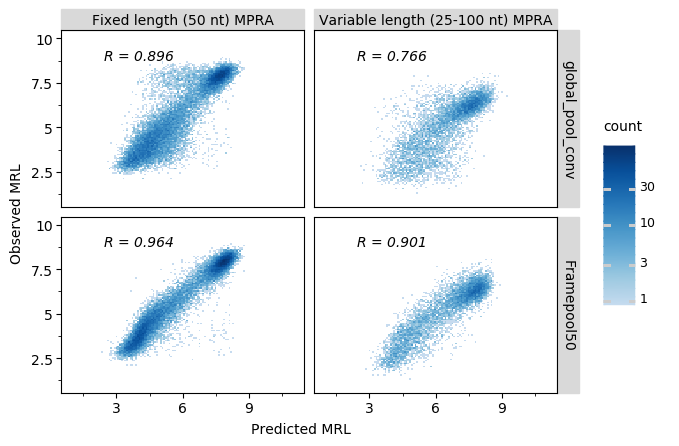

<ggplot: (-9223369073528975949)>

In [13]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["global_pool_conv","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "global_pool_conv", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [14]:
p.save("../Graphics/" + "globalpool" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/globalpool.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", a

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bin2d : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


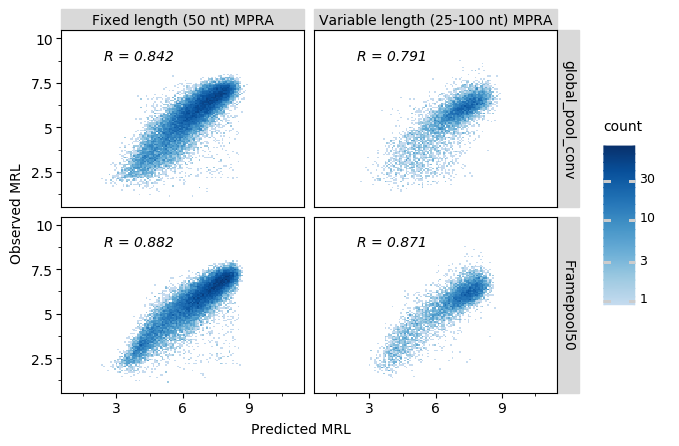

<ggplot: (-9223369072765958221)>

In [25]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["global_pool_conv","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "global_pool_conv", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [26]:
p.save("../Graphics/" + "globalpool_human" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/globalpool_human.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcpar

We observe:
* The model does worse than Framepool50 or Optimus50 on the 50nt data (because it has no frame information whatsoever)
* The model does better than Optimus50 on the variable length MPRA (as it doesnt require sequences to be truncated) but considerably worse than Framepool50 (because it still has no frame information)

# **Dilated Convolution**

In [14]:
mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[one_hot_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

In [23]:
dilated_conv = model.create_standard_conv_model(kernel_size=[7,7,7],
                        dilations=[1,2,4],
                        only_max_pool=False,
                        padding="same",
                        skip_connections="residual")

In [24]:
dilated_conv.fit_generator(generator_50, epochs=20, verbose=2, validation_data=X_y_val_50, callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)])

Epoch 1/20
 - 19s - loss: 1.9178 - val_loss: 0.9238
Epoch 2/20
 - 18s - loss: 1.0496 - val_loss: 0.5848
Epoch 3/20
 - 19s - loss: 0.8174 - val_loss: 0.4088
Epoch 4/20
 - 19s - loss: 0.6549 - val_loss: 0.3066
Epoch 5/20
 - 18s - loss: 0.5549 - val_loss: 0.2698
Epoch 6/20
 - 18s - loss: 0.4817 - val_loss: 0.2643
Epoch 7/20
 - 19s - loss: 0.4261 - val_loss: 0.2426
Epoch 8/20
 - 19s - loss: 0.3892 - val_loss: 0.2311
Epoch 9/20
 - 19s - loss: 0.3653 - val_loss: 0.2253
Epoch 10/20
 - 18s - loss: 0.3481 - val_loss: 0.2359
Epoch 11/20
 - 19s - loss: 0.3345 - val_loss: 0.2306
Epoch 12/20
 - 18s - loss: 0.3254 - val_loss: 0.2298


In [26]:
#save model
dilated_conv.save("../Models/utr_model_nonframe_dilated_residual.h5")

In [16]:
#load model
dilated_conv = load_model("../Models/utr_model_nonframe_dilated_residual.h5")

In [17]:
mpra_pred_df = pd.concat([build_mpra_prediction(dilated_conv, modelname="dilated_conv"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_mpra_prediction(dilated_conv, modelname="dilated_conv", human=True), mpra_pred_df_human]).reset_index(drop=True)

In [18]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,dilated_conv,Fixed length (50 nt) MPRA,0.965
20000,dilated_conv,Variable length (25-100 nt) MPRA,0.802
27600,global_pool_conv,Fixed length (50 nt) MPRA,0.896
47600,global_pool_conv,Variable length (25-100 nt) MPRA,0.766
55200,Optimus50,Fixed length (50 nt) MPRA,0.966
75200,Optimus50,Variable length (25-100 nt) MPRA,0.743
82800,Framepool50,Fixed length (50 nt) MPRA,0.964
102800,Framepool50,Variable length (25-100 nt) MPRA,0.901
110400,Optimus100,Fixed length (50 nt) MPRA,0.938
130400,Optimus100,Variable length (25-100 nt) MPRA,0.915


In [19]:
mpra_pred_df_human[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,dilated_conv,Fixed length (50 nt) MPRA,0.878
25000,dilated_conv,Variable length (25-100 nt) MPRA,0.813
32600,global_pool_conv,Fixed length (50 nt) MPRA,0.842
57600,global_pool_conv,Variable length (25-100 nt) MPRA,0.791
65200,Optimus50,Fixed length (50 nt) MPRA,0.889
90200,Optimus50,Variable length (25-100 nt) MPRA,0.700
97800,Framepool50,Fixed length (50 nt) MPRA,0.882
122800,Framepool50,Variable length (25-100 nt) MPRA,0.871
130400,Optimus100,Fixed length (50 nt) MPRA,0.852
155400,Optimus100,Variable length (25-100 nt) MPRA,0.882


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


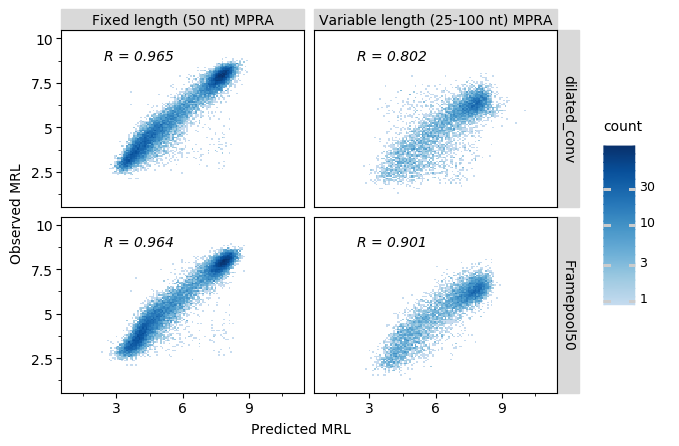

<ggplot: (2963468686775)>

In [20]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["dilated_conv","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "dilated_conv", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [21]:
p.save("../Graphics/" + "dilated" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/dilated.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", adde

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bin2d : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


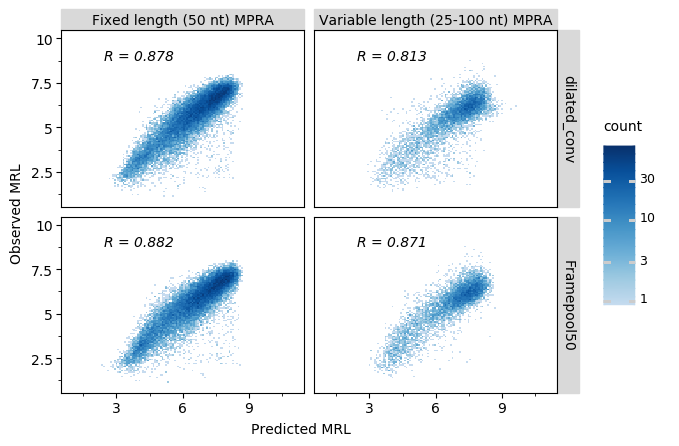

<ggplot: (2964108612770)>

In [22]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["dilated_conv","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "dilated_conv", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [24]:
p.save("../Graphics/" + "dilated_human" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/dilated_human.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam"

A dilated model does a lot better than an undilated model, but still generalizes noticeably worse to variable length data than the model with framepooling

### Adding more dilations

In [19]:
more_dilated_conv = model.create_standard_conv_model(kernel_size=[7,7,7,7],
                        dilations=[1,2,4,8],
                        only_max_pool=False,
                        padding="same",
                        skip_connections="residual")

In [20]:
more_dilated_conv.fit_generator(generator_50, epochs=20, verbose=2, validation_data=X_y_val_50, callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)])

Epoch 1/20
 - 35s - loss: 2.2072 - val_loss: 1.0888
Epoch 2/20
 - 32s - loss: 1.2551 - val_loss: 0.5619
Epoch 3/20
 - 39s - loss: 0.9366 - val_loss: 0.4640
Epoch 4/20
 - 34s - loss: 0.7394 - val_loss: 0.3414
Epoch 5/20
 - 31s - loss: 0.6041 - val_loss: 0.3404
Epoch 6/20
 - 31s - loss: 0.5056 - val_loss: 0.2911
Epoch 7/20
 - 35s - loss: 0.4552 - val_loss: 0.2724
Epoch 8/20
 - 31s - loss: 0.4317 - val_loss: 0.2695
Epoch 9/20
 - 30s - loss: 0.4221 - val_loss: 0.2763
Epoch 10/20
 - 39s - loss: 0.4117 - val_loss: 0.2714
Epoch 11/20
 - 30s - loss: 0.4029 - val_loss: 0.2414
Epoch 12/20
 - 30s - loss: 0.3699 - val_loss: 0.2410
Epoch 13/20
 - 38s - loss: 0.3476 - val_loss: 0.2295
Epoch 14/20
 - 30s - loss: 0.3367 - val_loss: 0.2294
Epoch 15/20
 - 30s - loss: 0.3299 - val_loss: 0.2385
Epoch 16/20
 - 34s - loss: 0.3228 - val_loss: 0.2618
Epoch 17/20
 - 31s - loss: 0.3143 - val_loss: 0.2621


In [22]:
#save model
more_dilated_conv.save("../Models/utr_model_nonframe_more_dilated_residual.h5")

In [24]:
mpra_pred_df = pd.concat([build_mpra_prediction(more_dilated_conv, modelname="more_dilated_conv"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_mpra_prediction(more_dilated_conv, modelname="more_dilated_conv", human=True), mpra_pred_df_human]).reset_index(drop=True)

In [25]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,more_dilated_conv,Fixed length (50 nt) MPRA,0.965
20000,more_dilated_conv,Variable length (25-100 nt) MPRA,0.801
27600,Optimus50,Fixed length (50 nt) MPRA,0.966
47600,Optimus50,Variable length (25-100 nt) MPRA,0.743
55200,Framepool50,Fixed length (50 nt) MPRA,0.964
75200,Framepool50,Variable length (25-100 nt) MPRA,0.901
82800,Optimus100,Fixed length (50 nt) MPRA,0.938
102800,Optimus100,Variable length (25-100 nt) MPRA,0.915
110400,Framepool100,Fixed length (50 nt) MPRA,0.929
130400,Framepool100,Variable length (25-100 nt) MPRA,0.903


In [26]:
mpra_pred_df_human[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,more_dilated_conv,Fixed length (50 nt) MPRA,0.882
25000,more_dilated_conv,Variable length (25-100 nt) MPRA,0.815
32600,Optimus50,Fixed length (50 nt) MPRA,0.889
57600,Optimus50,Variable length (25-100 nt) MPRA,0.700
65200,Framepool50,Fixed length (50 nt) MPRA,0.882
90200,Framepool50,Variable length (25-100 nt) MPRA,0.871
97800,Optimus100,Fixed length (50 nt) MPRA,0.852
122800,Optimus100,Variable length (25-100 nt) MPRA,0.882
130400,Framepool100,Fixed length (50 nt) MPRA,0.839
155400,Framepool100,Variable length (25-100 nt) MPRA,0.884


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


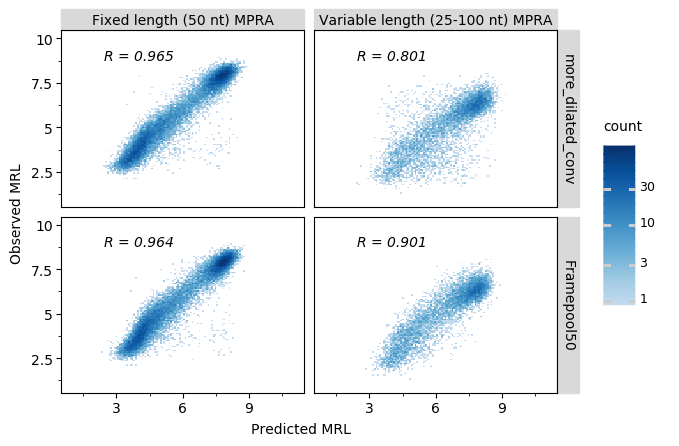

<ggplot: (-9223369087300649440)>

In [27]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["more_dilated_conv","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "more_dilated_conv", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [28]:
p.save("../Graphics/" + "more_dilated" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/more_dilated.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam",

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bin2d : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


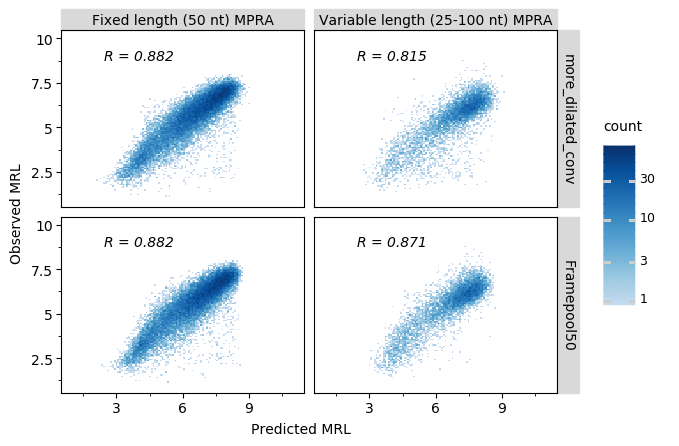

<ggplot: (2949553964657)>

In [29]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["more_dilated_conv","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "more_dilated_conv", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [30]:
p.save("../Graphics/" + "more_dilated_human" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/more_dilated_human.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcp

# **Random Forests**

Maybe we do not need neural networks at all and can instead use random forests trained on k-mers. This would also generalize to arbitrary length sequences

## Testing code

In [7]:
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")

### Extracting kmer counts

In [8]:
# extract kmers
kmer_extractor = utils_data.KmerExtractor(seq_col="utr", new_col="kmer_count", k=4, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

Doing precomputation: kmer_count


In [9]:
generator_50.df[["utr", "kmer_count"]].iloc[0]["utr"]

'CCAATATCGTATCCCAATAACGCAAAACGGCGTAGCAAACGCTACATTCA'

In [10]:
generator_50.df[["utr", "kmer_count"]].iloc[0]["kmer_count"]

array([1., 2., 0., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0.

###  3-mer random forest

In [12]:
# extract kmers
kmer_extractor = utils_data.KmerExtractor(seq_col="utr", new_col="kmer_count", k=3, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True, batch_size=len(train_data_50))
X_train, y_train = [(X[0],y) for X,y in generator_50][0]

Doing precomputation: kmer_count


In [13]:
rf_3 = ensemble.RandomForestRegressor(n_estimators=100, verbose=3, n_jobs=10)

In [ ]:
rf_3.fit(X_train, y_train)

In [15]:
with open(Path("../Models/3mer_rf.joblib"), 'wb') as handle:
    dump(rf_3, handle)

In [16]:
mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_3, kmer_extractor, modelname="3mer_random_forest"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_3, kmer_extractor, modelname="3mer_random_forest", human=True), mpra_pred_df_human]).reset_index(drop=True)

Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.2s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [17]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,3mer_random_forest,Fixed length (50 nt) MPRA,0.732
20000,3mer_random_forest,Variable length (25-100 nt) MPRA,0.616
27600,Optimus50,Fixed length (50 nt) MPRA,0.966
47600,Optimus50,Variable length (25-100 nt) MPRA,0.743
55200,Framepool50,Fixed length (50 nt) MPRA,0.964
75200,Framepool50,Variable length (25-100 nt) MPRA,0.901
82800,Optimus100,Fixed length (50 nt) MPRA,0.938
102800,Optimus100,Variable length (25-100 nt) MPRA,0.915
110400,Framepool100,Fixed length (50 nt) MPRA,0.929
130400,Framepool100,Variable length (25-100 nt) MPRA,0.903


In [18]:
mpra_pred_df_human[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,3mer_random_forest,Fixed length (50 nt) MPRA,0.763
25000,3mer_random_forest,Variable length (25-100 nt) MPRA,0.592
32600,Optimus50,Fixed length (50 nt) MPRA,0.889
57600,Optimus50,Variable length (25-100 nt) MPRA,0.700
65200,Framepool50,Fixed length (50 nt) MPRA,0.882
90200,Framepool50,Variable length (25-100 nt) MPRA,0.871
97800,Optimus100,Fixed length (50 nt) MPRA,0.852
122800,Optimus100,Variable length (25-100 nt) MPRA,0.882
130400,Framepool100,Fixed length (50 nt) MPRA,0.839
155400,Framepool100,Variable length (25-100 nt) MPRA,0.884


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


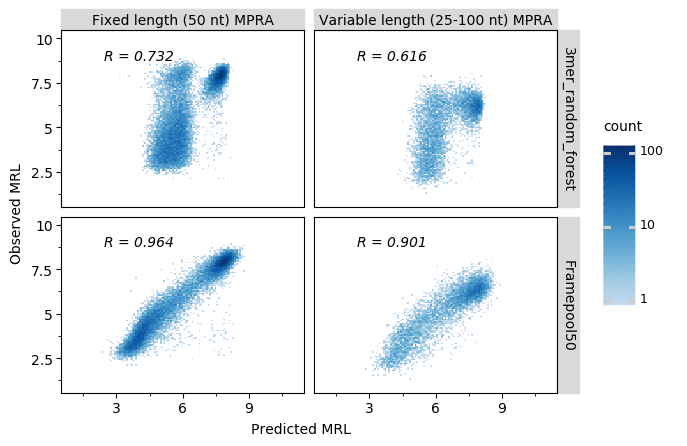

<ggplot: (1397240257393)>

In [19]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["3mer_random_forest","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "3mer_random_forest", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [20]:
p.save("../Graphics/" + "3merRF" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/3merRF.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", adden

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bin2d : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


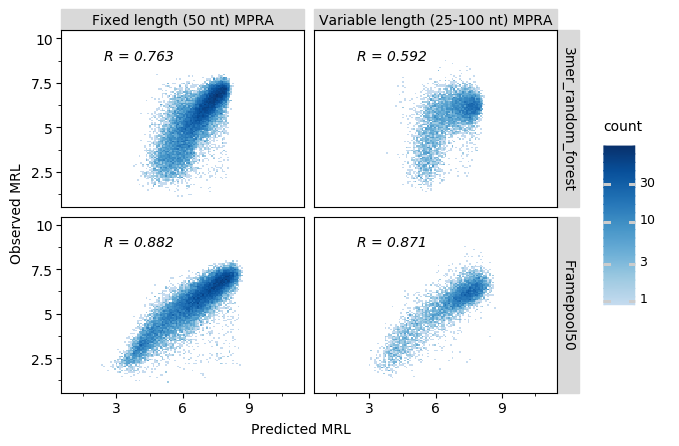

<ggplot: (1397225564911)>

In [22]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["3mer_random_forest","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "3mer_random_forest", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [23]:
p.save("../Graphics/" + "3merRF_human" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/3merRF_human.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam",

### 4-mer random forest

In [9]:
# extract kmers
kmer_extractor = utils_data.KmerExtractor(seq_col="utr", new_col="kmer_count", k=4, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True, batch_size=len(train_data_50))
X_train, y_train = [(X[0],y) for X,y in generator_50][0]

Doing precomputation: kmer_count


In [ ]:
rf_4 = ensemble.RandomForestRegressor(n_estimators=100, verbose=3, n_jobs=10)
rf_4.fit(X_train, y_train)

In [11]:
with open(Path("../Models/4mer_rf.joblib"), 'wb') as handle:
    dump(rf_4, handle)

In [12]:
mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_4, kmer_extractor, modelname="4mer_random_forest"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_4, kmer_extractor, modelname="4mer_random_forest", human=True), mpra_pred_df_human]).reset_index(drop=True)

Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [13]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,4mer_random_forest,Fixed length (50 nt) MPRA,0.750
20000,4mer_random_forest,Variable length (25-100 nt) MPRA,0.647
27600,Optimus50,Fixed length (50 nt) MPRA,0.966
47600,Optimus50,Variable length (25-100 nt) MPRA,0.743
55200,Framepool50,Fixed length (50 nt) MPRA,0.964
75200,Framepool50,Variable length (25-100 nt) MPRA,0.901
82800,Optimus100,Fixed length (50 nt) MPRA,0.938
102800,Optimus100,Variable length (25-100 nt) MPRA,0.915
110400,Framepool100,Fixed length (50 nt) MPRA,0.929
130400,Framepool100,Variable length (25-100 nt) MPRA,0.903


In [14]:
mpra_pred_df_human[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,4mer_random_forest,Fixed length (50 nt) MPRA,0.767
25000,4mer_random_forest,Variable length (25-100 nt) MPRA,0.668
32600,Optimus50,Fixed length (50 nt) MPRA,0.889
57600,Optimus50,Variable length (25-100 nt) MPRA,0.700
65200,Framepool50,Fixed length (50 nt) MPRA,0.882
90200,Framepool50,Variable length (25-100 nt) MPRA,0.871
97800,Optimus100,Fixed length (50 nt) MPRA,0.852
122800,Optimus100,Variable length (25-100 nt) MPRA,0.882
130400,Framepool100,Fixed length (50 nt) MPRA,0.839
155400,Framepool100,Variable length (25-100 nt) MPRA,0.884


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


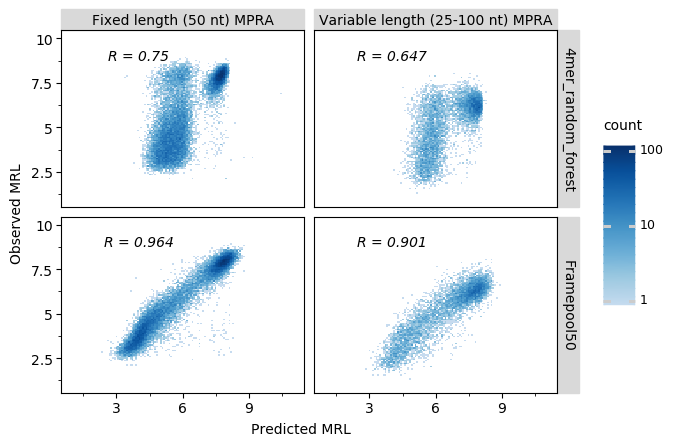

<ggplot: (-9223370638619694087)>

In [15]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["4mer_random_forest","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "4mer_random_forest", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [16]:
p.save("../Graphics/" + "4merRF" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/4merRF.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", adden

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bin2d : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


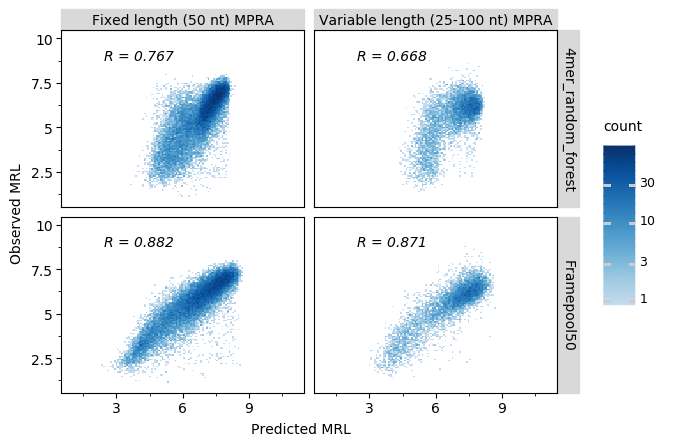

<ggplot: (1398223857784)>

In [17]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["4mer_random_forest","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "4mer_random_forest", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [18]:
p.save("../Graphics/" + "4merRF_human" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/4merRF_human.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam",

# **Frame forest**

In [21]:
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
# extract kmers
kmer_extractor = utils_data.FramedKmerExtractor(seq_col="utr", new_col="kmer_count", k=4, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True, batch_size=len(train_data_50))
X_train, y_train = [(X[0],y) for X,y in generator_50][0]

Doing precomputation: kmer_count


In [22]:
X_train.shape

(240000, 768)

In [ ]:
rf_frame = ensemble.RandomForestRegressor(n_estimators=100, verbose=3, n_jobs=10)
rf_frame.fit(X_train, y_train)

In [24]:
with open(Path("../Models/framed_rf.joblib"), 'wb') as handle:
    dump(rf_frame, handle)

In [25]:
mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest", human=True), mpra_pred_df_human]).reset_index(drop=True)

Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.2s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [26]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,frame_forest,Fixed length (50 nt) MPRA,0.877
20000,frame_forest,Variable length (25-100 nt) MPRA,0.772
27600,Optimus50,Fixed length (50 nt) MPRA,0.966
47600,Optimus50,Variable length (25-100 nt) MPRA,0.743
55200,Framepool50,Fixed length (50 nt) MPRA,0.964
75200,Framepool50,Variable length (25-100 nt) MPRA,0.901
82800,Optimus100,Fixed length (50 nt) MPRA,0.938
102800,Optimus100,Variable length (25-100 nt) MPRA,0.915
110400,Framepool100,Fixed length (50 nt) MPRA,0.929
130400,Framepool100,Variable length (25-100 nt) MPRA,0.903


In [27]:
mpra_pred_df_human[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,frame_forest,Fixed length (50 nt) MPRA,0.762
25000,frame_forest,Variable length (25-100 nt) MPRA,0.739
32600,Optimus50,Fixed length (50 nt) MPRA,0.889
57600,Optimus50,Variable length (25-100 nt) MPRA,0.700
65200,Framepool50,Fixed length (50 nt) MPRA,0.882
90200,Framepool50,Variable length (25-100 nt) MPRA,0.871
97800,Optimus100,Fixed length (50 nt) MPRA,0.852
122800,Optimus100,Variable length (25-100 nt) MPRA,0.882
130400,Framepool100,Fixed length (50 nt) MPRA,0.839
155400,Framepool100,Variable length (25-100 nt) MPRA,0.884


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


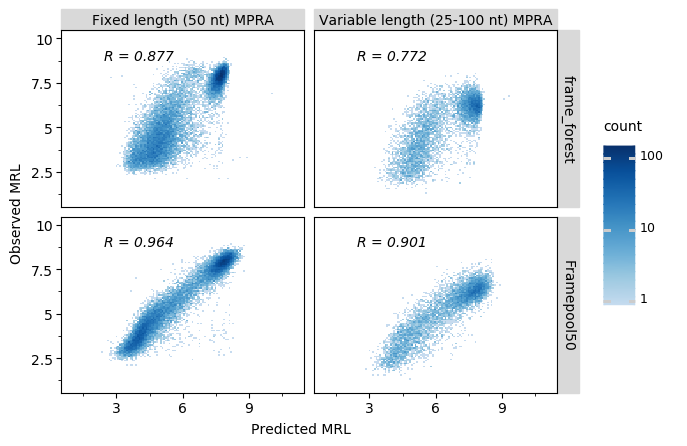

<ggplot: (-9223370611359972187)>

In [28]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["frame_forest","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "frame_forest", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [29]:
p.save("../Graphics/" + "framed_RF" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/framed_RF.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", ad

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bin2d : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


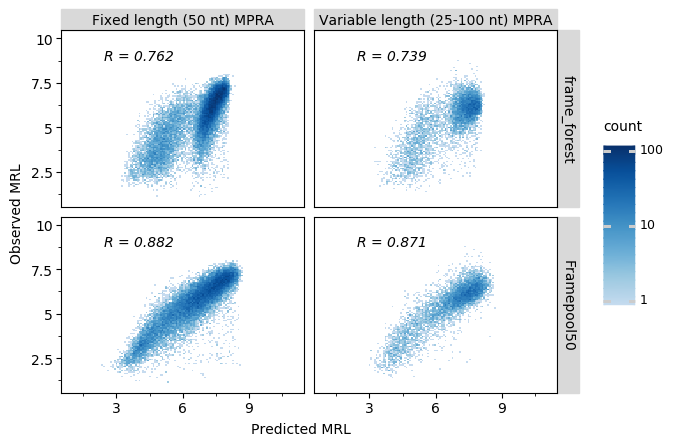

<ggplot: (1425486447624)>

In [30]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["frame_forest","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "frame_forest", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [31]:
p.save("../Graphics/" + "framed_RF_human" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/framed_RF_human.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcpara

Comparing framed and unframed forest

In [8]:
with open(Path("../Models/framed_rf.joblib"), 'rb') as handle:
    rf_frame = load(handle)

In [10]:
with open(Path("../Models/4mer_rf.joblib"), 'rb') as handle:
    rf_4mer = load(handle)

In [11]:
# extract kmers
kmer_extractor = utils_data.KmerExtractor(seq_col="utr", new_col="kmer_count", k=4, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True, batch_size=len(train_data_50))
X_train, y_train = [(X[0],y) for X,y in generator_50][0]

mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_4mer, kmer_extractor, modelname="4mer_random_forest"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_4mer, kmer_extractor, modelname="4mer_random_forest", human=True), mpra_pred_df_human]).reset_index(drop=True)

out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
# extract kmers
kmer_extractor = utils_data.FramedKmerExtractor(seq_col="utr", new_col="kmer_count", k=4, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True, batch_size=len(train_data_50))
X_train, y_train = [(X[0],y) for X,y in generator_50][0]

mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest", human=True), mpra_pred_df_human]).reset_index(drop=True)

Doing precomputation: kmer_count
Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


Doing precomputation: kmer_count
Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


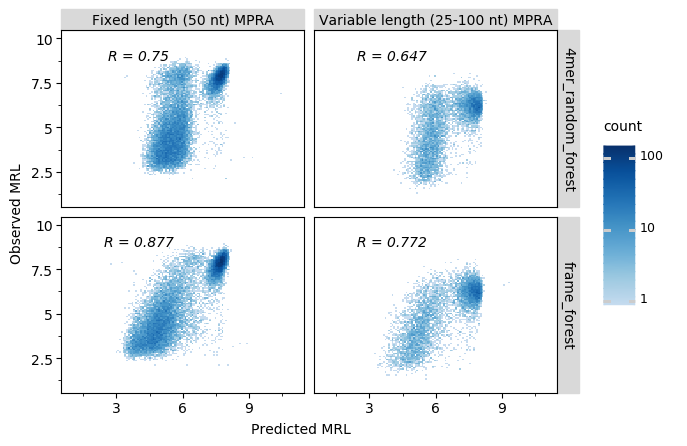

<ggplot: (2942033547535)>

In [12]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["4mer_random_forest", "frame_forest"])]

# Fix labels
plotlabel_dict = {"A": "4mer_random_forest", "B": "frame_forest", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [13]:
p.save("../Graphics/" + "framedvunframed_RF" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/framedvunframed_RF.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcp

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


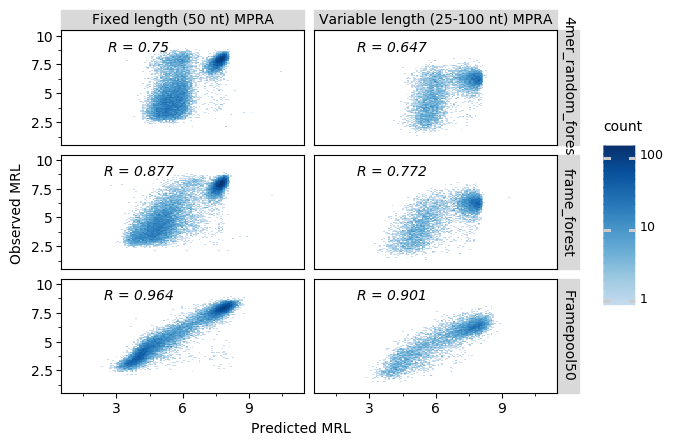

<ggplot: (-9223369094822223970)>

In [16]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["4mer_random_forest", "frame_forest", "Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "4mer_random_forest", "B": "frame_forest", "C": "Framepool50", "D": "Fixed length (50 nt) MPRA", "E": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

### Hyperopt the framed random forest

In [4]:
!sbatch -N 1 -c 16 --mem 60G --error /s/project/multispecies/Modelling/Translatome/Pipeline/job_reports/job.%J.err --output /s/project/multispecies/Modelling/Translatome/Pipeline/job_reports/job.%J.out -J hyperopt_pipe -p slurm-ouga -w ouga05 hyperopt_call.sh

Submitted batch job 407089


In [7]:
# To check how your job is doing
!sacct

       JobID    JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
400112       spawner-j+ slurm-ouga                     4    RUNNING      0:0 
400112.batch      batch                                4    RUNNING      0:0 
407077       spawner-j+ slurm-ouga                     4    RUNNING      0:0 
407077.batch      batch                                4    RUNNING      0:0 
407089       hyperopt_+ slurm-ouga                    16    RUNNING      0:0 
407089.batch      batch                               16    RUNNING      0:0 


# Run hyperparameter optimized Frame Forest

In [8]:
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
# extract kmers
kmer_extractor = utils_data.FramedKmerExtractor(seq_col="utr", new_col="kmer_count", k=4, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True, batch_size=len(train_data_50))
X_train, y_train = [(X[0],y) for X,y in generator_50][0]

Doing precomputation: kmer_count


In [ ]:
rf_frame = ensemble.RandomForestRegressor(n_estimators=200, verbose=3, max_depth=32, n_jobs=10)
rf_frame.fit(X_train, y_train)

In [10]:
with open(Path("../Models/framed_hyperopt_rf.joblib"), 'wb') as handle:
    dump(rf_frame, handle)

In [11]:
mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest", human=True), mpra_pred_df_human]).reset_index(drop=True)

Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.6s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.2s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.7s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.2s finished


In [13]:
print(mpra_pred_df[["model", "data", "R"]].drop_duplicates())
print(mpra_pred_df_human[["model", "data", "R"]].drop_duplicates())

                    model                              data      R
0            frame_forest         Fixed length (50 nt) MPRA  0.876
20000        frame_forest  Variable length (25-100 nt) MPRA  0.778
27600           Optimus50         Fixed length (50 nt) MPRA  0.966
47600           Optimus50  Variable length (25-100 nt) MPRA  0.743
55200         Framepool50         Fixed length (50 nt) MPRA  0.964
75200         Framepool50  Variable length (25-100 nt) MPRA  0.901
82800          Optimus100         Fixed length (50 nt) MPRA  0.938
102800         Optimus100  Variable length (25-100 nt) MPRA  0.915
110400       Framepool100         Fixed length (50 nt) MPRA  0.929
130400       Framepool100  Variable length (25-100 nt) MPRA  0.903
138000  FramepoolCombined         Fixed length (50 nt) MPRA  0.954
158000  FramepoolCombined  Variable length (25-100 nt) MPRA  0.914
                    model                              data      R
0            frame_forest         Fixed length (50 nt) MPRA  0

# More Trees

In [7]:
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
# extract kmers
kmer_extractor = utils_data.FramedKmerExtractor(seq_col="utr", new_col="kmer_count", k=4, jump=False, divide_counts=False)

mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
generator_50 = utils_data.DataSequence(train_data_50, encoding_functions=[], precomputations=[kmer_extractor],
                                    output_encoding_fn=out_encoding_fn, shuffle=True, batch_size=len(train_data_50))
X_train, y_train = [(X[0],y) for X,y in generator_50][0]

Doing precomputation: kmer_count


In [ ]:
rf_frame = ensemble.RandomForestRegressor(n_estimators=1000, verbose=3, max_depth=32, n_jobs=10)
rf_frame.fit(X_train, y_train)

In [9]:
mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest", human=True), mpra_pred_df_human]).reset_index(drop=True)

print(mpra_pred_df[["model", "data", "R"]].drop_duplicates())
print(mpra_pred_df_human[["model", "data", "R"]].drop_duplicates())

Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    1.8s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    0.6s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    2.0s finished


Doing precomputation: kmer_count


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    0.6s finished


                    model                              data      R
0            frame_forest         Fixed length (50 nt) MPRA  0.876
20000        frame_forest  Variable length (25-100 nt) MPRA  0.778
27600           Optimus50         Fixed length (50 nt) MPRA  0.966
47600           Optimus50  Variable length (25-100 nt) MPRA  0.743
55200         Framepool50         Fixed length (50 nt) MPRA  0.964
75200         Framepool50  Variable length (25-100 nt) MPRA  0.901
82800          Optimus100         Fixed length (50 nt) MPRA  0.938
102800         Optimus100  Variable length (25-100 nt) MPRA  0.915
110400       Framepool100         Fixed length (50 nt) MPRA  0.929
130400       Framepool100  Variable length (25-100 nt) MPRA  0.903
138000  FramepoolCombined         Fixed length (50 nt) MPRA  0.954
158000  FramepoolCombined  Variable length (25-100 nt) MPRA  0.914
                    model                              data      R
0            frame_forest         Fixed length (50 nt) MPRA  0

In [10]:
with open(Path("../Models/framed_1000_rf.joblib"), 'wb') as handle:
    dump(rf_frame, handle)

### 5-mer Framed Forest

In [14]:
from scipy import sparse

# Extracts kmers for each frame
class FramedKmerSparseExtractor():

    def __init__(self, seq_col, k, jump=False):
        self.k = k
        self.seq_col = seq_col
        kmers = [''.join(i) for i in itertools.product(["A","C","T","G"], repeat = self.k)]
        self.n = len(kmers)
        self.kmer_dict = {kmers[k]:k for k in range(self.n)}
        self.jump = jump

    def extract(self, seq):
        i = 1
        indices = []
        while i <= len(seq) - (self.k - 1):
            j = len(seq) - (self.k - 1) - i
            col_idx = ((i % 3) + 1)*self.kmer_dict[seq[j:j+self.k]]
            indices.append(col_idx)
            if self.jump:
                i = i + self.k
            else:
                i += 1
        return indices

    def __call__(self, df):
        dok_mat = sparse.dok_matrix((len(df), (3*(4 ** self.k))), np.float(32))
        for row_idx, row in enumerate(df[self.seq_col]):
            col_indices = self.extract(row)
            for col_idx in col_indices:
                dok_mat[row_idx, col_idx] = dok_mat[row_idx, col_idx] + 1
            if row_idx % 10000 == 0:
                print(row_idx)
        return sparse.csr_matrix(dok_mat)

In [25]:
mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
kmer_extractor = FramedKmerSparseExtractor(seq_col="utr", k=5)
X_train = kmer_extractor.__call__(train_data_50)
y_train = np.array(train_data_50["rl"])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000


In [16]:
sparse.save_npz("../Data/5_mer_mat.npz", X_train)

In [ ]:
rf_frame = ensemble.RandomForestRegressor(n_estimators=200, max_depth=32, max_features="auto", verbose=3, n_jobs=-1)
rf_frame.fit(X_train, y_train)

In [27]:
with open(Path("../Models/framed_5mer_rf.joblib"), 'wb') as handle:
    dump(rf_frame, handle)

In [29]:
def rf_predict_on_MPRA(model, kmer_extractor, data_dict, varlen = False, library = "egfp_unmod_1"):
    if varlen:
        data_df = data_dict["varlen_mpra"].copy()
    else:
        data_df = data_dict["mpra"].copy()
    df = data_df[(data_df.library == library) & (data_df.set == "test")]
    X = kmer_extractor.__call__(df)
    predict = model.predict(X)
    df["pred"] = predict
    df = df.rename(columns={"pred": "Predicted MRL", "rl": "Observed MRL"})
    return df

def build_rf_mpra_prediction(predmodel, kmer_extractor, modelname, human=False):
    concat_df = pd.DataFrame(columns=['Predicted MRL', 'Observed MRL', 'model', 'data', 'R'])
    data_types = [("Fixed length (50 nt) MPRA", "egfp_unmod_1", False), ("Variable length (25-100 nt) MPRA", "random", True)]
    if human:
        data_types = [("Fixed length (50 nt) MPRA", "human", False), ("Variable length (25-100 nt) MPRA", "human", True)]
    for data in data_types:
        varlen = data[2]
        dataname = data[0]
        library = data[1]
        pred_df = rf_predict_on_MPRA(predmodel, kmer_extractor, data_dict, varlen = varlen, library = library)
        pred_df = pred_df[["Predicted MRL", "Observed MRL"]]
        #print((modelname, dataname))
        pred_df["model"] = modelname
        pred_df["data"] = dataname
        pred_df["R"] = round(stats.pearsonr(pred_df["Predicted MRL"], pred_df["Observed MRL"])[0], 3)
        concat_df = pd.concat([concat_df, pred_df])
    return concat_df

In [32]:
mpra_pred_df = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest_5mer"), mpra_pred_df]).reset_index(drop=True)
mpra_pred_df_human = pd.concat([build_rf_mpra_prediction(rf_frame, kmer_extractor, modelname="frame_forest_5mer", human=True), mpra_pred_df_human]).reset_index(drop=True)
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

0
10000


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished


0


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


0
10000
20000


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished


0


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


,model,data,R
0,frame_forest_5mer,Fixed length (50 nt) MPRA,0.803
20000,frame_forest_5mer,Variable length (25-100 nt) MPRA,0.730
27600,Optimus50,Fixed length (50 nt) MPRA,0.966
47600,Optimus50,Variable length (25-100 nt) MPRA,0.743
55200,Framepool50,Fixed length (50 nt) MPRA,0.964
75200,Framepool50,Variable length (25-100 nt) MPRA,0.901
82800,Optimus100,Fixed length (50 nt) MPRA,0.938
102800,Optimus100,Variable length (25-100 nt) MPRA,0.915
110400,Framepool100,Fixed length (50 nt) MPRA,0.929
130400,Framepool100,Variable length (25-100 nt) MPRA,0.903


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


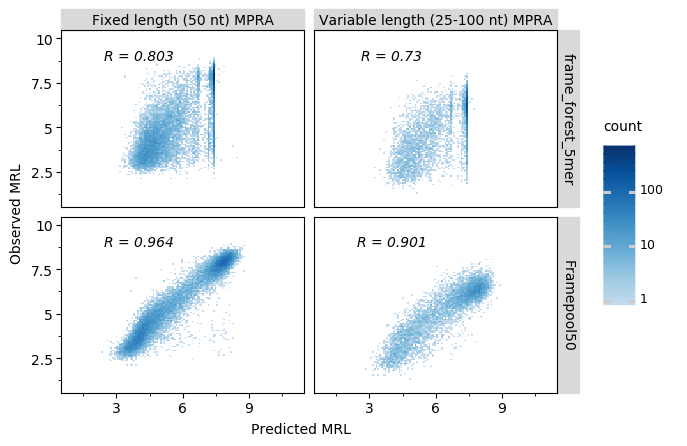

<ggplot: (2971498771583)>

In [33]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["frame_forest_5mer","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "frame_forest_5mer", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [34]:
p.save("../Graphics/" + "framed_RF_5mer" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/framed_RF_5mer.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bin2d : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


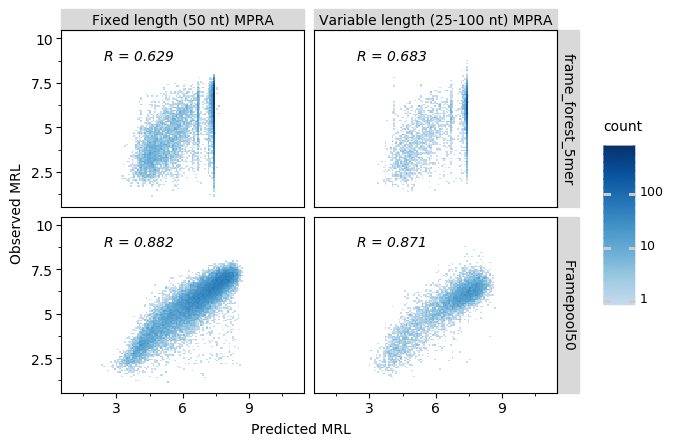

<ggplot: (2971381298829)>

In [35]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["frame_forest_5mer","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "frame_forest_5mer", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 4, y = 9, label = "R"), fontstyle = "italic")
 + plotnine.xlim(1,11) + plotnine.ylim(1,10)
 + plotnine.theme_matplotlib())
p

In [36]:
p.save("../Graphics/" + "framed_RF_5mer_human" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/framed_RF_5mer_human.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="r